# **MODELOS DE REGRESIÓN PARA LA PREDICCIÓN**

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score, precision_score,
    recall_score, f1_score, roc_auc_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
)
from sklearn.linear_model import Ridge, Lasso
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

In [2]:
returns = pd.read_csv("finalproject_data.csv")
returns = returns[['Return on Assets (ttm)', 'Return on Equity (ttm)', 'Return on Investment (ttm)']]
esg = pd.read_csv("proyectofinallimpio.csv")
data = pd.concat([esg, returns], axis=1)

## **Encoder**

In [3]:
cats = data.select_dtypes(include=['object', 'category']).drop(columns= ['Controversy Level', 'Symbol', 'Name'])
cat_columns = cats.columns

In [4]:
cats.columns

Index(['Sector', 'Industry', 'Controversy Score', 'ESG Risk Level'], dtype='object')

In [5]:
cats # Variables a encodear

,Sector,Industry,Controversy Score,ESG Risk Level
0,Technology,Solar,Moderado,Medium
1,Basic Materials,Specialty Chemicals,Moderado,Medium
2,Consumer Cyclical,Restaurants,Moderado,Medium
3,Healthcare,Medical Care Facilities,Moderado,Medium
4,Consumer Cyclical,Restaurants,Moderado,Medium
...,...,...,...,...
458,Technology,Information Technology Services,Moderado,Negligible
459,Healthcare,Drug Manufacturers - General,Significativo,Medium
460,Healthcare,Medical Devices,Significativo,Medium
461,Industrials,Specialty Industrial Machinery,Bajo,Medium


In [6]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
cats_encoded = encoder.fit_transform(cats[cat_columns])
cats_encoded = pd.DataFrame(cats_encoded, columns=encoder.get_feature_names_out(cat_columns))

In [7]:
modeldata = pd.concat([data.drop(columns= ['Controversy Level', 'Sector', 'Industry', 'Controversy Score', 'ESG Risk Level', 'Symbol', 'Name', 'ESG Risk Percentile']), cats_encoded], axis = 1)

In [8]:
modeldata

,Full Time Employees,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Return on Assets (ttm),Return on Equity (ttm),Return on Investment (ttm),Sector_Communication Services,Sector_Consumer Cyclical,...,Industry_Utilities - Renewable,Industry_Waste Management,Controversy Score_Bajo,Controversy Score_Moderado,Controversy Score_Severo,Controversy Score_Significativo,ESG Risk Level_Low,ESG Risk Level_Medium,ESG Risk Level_Negligible,ESG Risk Level_Severe
0,3157.0,21.502051,5.732427,6.72621,9.042999,0.152,0.717,0.186,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,14000.0,25.300000,12.800000,6.60000,5.800000,0.053,0.146,0.095,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6500.0,29.200000,10.600000,6.30000,12.200000,0.274,-0.107,0.777,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,70000.0,22.600000,0.100000,8.40000,14.100000,0.033,0.832,0.118,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,187384.0,27.500000,7.900000,4.60000,15.000000,0.090,0.424,0.248,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,742000.0,9.800000,0.800000,4.40000,4.600000,0.153,0.324,0.319,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
459,50000.0,29.900000,2.400000,10.40000,17.200000,0.083,0.734,0.205,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
460,114000.0,24.800000,2.300000,8.30000,14.200000,0.094,0.192,0.130,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
461,12000.0,25.400000,7.200000,6.40000,11.900000,0.071,0.133,0.113,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## **Modelos**

In [9]:
X = modeldata.drop(columns=['Return on Assets (ttm)','Return on Equity (ttm)', 'Return on Investment (ttm)']) # Se toman todas las columnas excepto la objetivo
y1 = modeldata['Return on Assets (ttm)'] # Se toma solo la primera columna objetivo 
y2 = modeldata['Return on Equity (ttm)'] # Se toma solo la segunda columna objetivo
y3 = modeldata['Return on Investment (ttm)'] # Se toma solo la tercera columna objetivo

In [10]:
def residuos(y_test, y_prediccion):
    residuo = y_test - y_prediccion
    ljung = acorr_ljungbox(residuo, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jarque = jarque_bera(residuo)  
    jarque = jarque[1]
    return ljung, jarque

### **ROA (Return on Assets (ttm))**

In [11]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, random_state=58)
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

#### **KNN**

In [12]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': list(range(1, 100)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X1_train, y1_train)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X1_test)

r2 = r2_score(y1_test, y_pred)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print(f'R²: {r2:.2f}')

Mejores parámetros encontrados:
{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 4, 'weights': 'uniform'}
R²: 0.08


#### **Regresión lineal**

In [13]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),('lr', LinearRegression())])
lr_paramgrid = {} # No tiene hiperpárametros definidos

lr_grid = GridSearchCV(lr_pipeline, param_grid = lr_paramgrid, cv = 10, scoring= 'r2')
lr_grid.fit(X1_train, y1_train)

print("Mejor score (R2) en entrenamiento:", lr_grid.best_score_)

y_pred = lr_grid.predict(X1_test)
r_square = r2_score(y1_test, y_pred)
rmse_ = np.sqrt(mean_squared_error(y1_test, y_pred))

print("R2 en el conjunto de test para Regresión Lineal:", r_square)
print("RMSE en el conjunto de test para Regresión Lineal:",rmse_)

Mejor score (R2) en entrenamiento: -6.3033782597087e+27
R2 en el conjunto de test para Regresión Lineal: -4.427950148739381e+26
RMSE en el conjunto de test para Regresión Lineal: 1703350455729.5056


#### **Regresión Ridge**

In [14]:
ridge = Ridge().fit(X1_train, y1_train)
print("Training set score: {:.2f}".format(ridge.score(X1_train, y1_train)))
print("Test set score: {:.2f}".format(ridge.score(X1_test, y1_test)))


Training set score: 0.56
Test set score: 0.13


#### **Regresión Lasso**

In [15]:
lasso = Lasso().fit(X1_train, y1_train)
print("Training set score: {:.2f}".format(lasso.score(X1_train, y1_train)))
print("Test set score: {:.2f}".format(lasso.score(X1_test, y1_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.00
Test set score: -0.02
Number of features used: 0


#### **TABLA**

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Realizar predicciones
KNN1 = best_knn.predict(X1_test)
LR1 = lr_grid.predict(X1_test)
RIDGE1 = ridge.predict(X1_test)
LASSO1 = lasso.predict(X1_test)

# Evaluar las predicciones utilizando métricas de regresión
metricas = {
    'Modelo': ['KNN', 'Regresión lineal', 'Ridge', 'Lasso'],
    'Mean Squared Error (MSE)': [
        mean_squared_error(y1_test, KNN1),  # K-NN
        mean_squared_error(y1_test, LR1),   # Regresión lineal
        mean_squared_error(y1_test, RIDGE1),
        mean_squared_error(y1_test, LASSO1)
    ],
    'Root Mean Squared Error (RMSE)': [
        np.sqrt(mean_squared_error(y1_test, KNN1)),
        np.sqrt(mean_squared_error(y1_test, LR1)),
        np.sqrt(mean_squared_error(y1_test, RIDGE1)),
        np.sqrt(mean_squared_error(y1_test, LASSO1))
    ],
    'Mean Absolute Error (MAE)': [
        mean_absolute_error(y1_test, KNN1),
        mean_absolute_error(y1_test, LR1),
        mean_absolute_error(y1_test, RIDGE1),
        mean_absolute_error(y1_test, LASSO1)
    ],
    'R2 score':[
        r2_score(y1_test, KNN1),
        r2_score(y1_test, LR1),
        r2_score(y1_test, RIDGE1),
        r2_score(y1_test, LASSO1)
    ],

    'Ljung-Box (p-value)': [
        residuos(y1_test, KNN1)[0],
        residuos(y1_test, LR1)[0],
        residuos(y1_test, RIDGE1)[0],
        residuos(y1_test, LASSO1)[0]
    ],
    'Jarque-Bera (p-value)': [
        residuos(y1_test, KNN1)[1],
        residuos(y1_test, LR1)[1],
        residuos(y1_test, RIDGE1)[1],
        residuos(y1_test, LASSO1)[1]
    ]
    
}

# Convertir a DataFrame para visualización
cuadro1 = pd.DataFrame(metricas)
cuadro1


,Modelo,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R2 score,Ljung-Box (p-value),Jarque-Bera (p-value)
0,KNN,6.052576e-03,7.779830e-02,5.599819e-02,7.629148e-02,0.206972,3.569842e-04
1,Regresión lineal,2.901403e+24,1.703350e+12,4.934784e+11,-4.427950e+26,0.997864,0.000000e+00
2,Ridge,5.714636e-03,7.559521e-02,5.386722e-02,1.278659e-01,0.311085,5.347736e-08
3,Lasso,6.704687e-03,8.188215e-02,5.931734e-02,-2.322988e-02,0.746134,1.386132e-09


En resumen, KNN, Ridge y Lasso muestran buen rendimiento con bajos errores (MSE, RMSE y MAE), aunque los residuos no siguen una distribución normal según la prueba de Jarque-Bera. La Regresión Lineal tiene un rendimiento muy deficiente, con errores extremadamente altos, lo que indica que no es adecuada para este problema. No hay autocorrelación significativa en los residuos de ninguno de los modelos, lo que es positivo.

#### **GRÁFICAS**

##### **KNN**

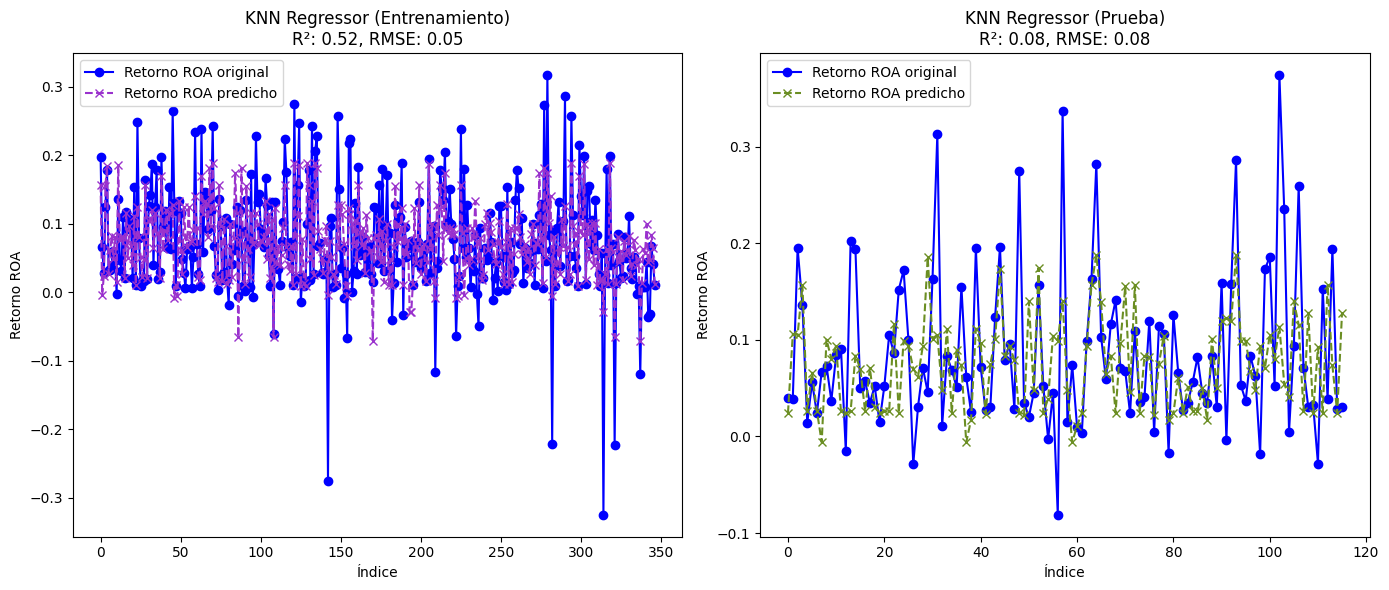

In [17]:
y_train_pred = best_knn.predict(X1_train)
y_test_pred = best_knn.predict(X1_test)

r2_train_knn = r2_score(y1_train, y_train_pred)
r2_test_knn = r2_score(y1_test, y_test_pred)

rmse_train_knn = np.sqrt(mean_squared_error(y1_train, y_train_pred))
rmse_test_knn = np.sqrt(mean_squared_error(y1_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y1_train)), y1_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Entrenamiento)\nR²: {r2_train_knn:.2f}, RMSE: {rmse_train_knn:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y1_test)), y1_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Regresión lineal**

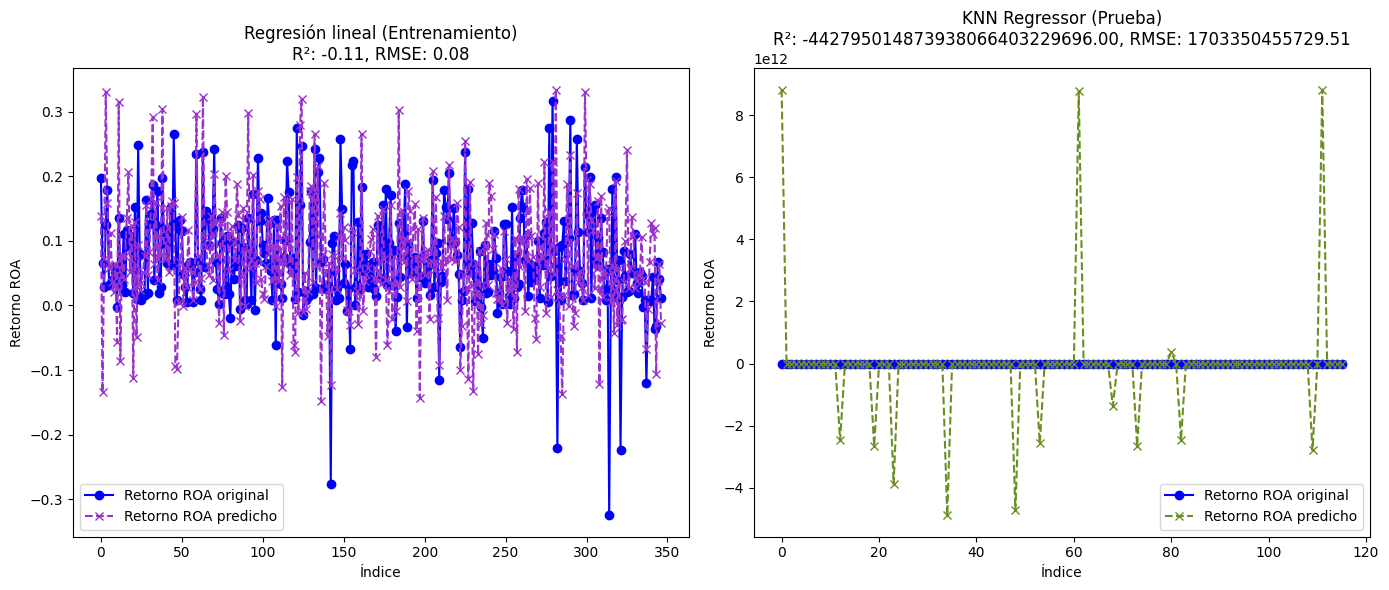

In [18]:
y_train_pred = lr_grid.predict(X1_train)
y_test_pred = lr_grid.predict(X1_test)

r2_train_lr = r2_score(y1_train, y_train_pred)
r2_test_lr = r2_score(y1_test, y_test_pred)

rmse_train_lr = np.sqrt(mean_squared_error(y1_train, y_train_pred))
rmse_test_lr = np.sqrt(mean_squared_error(y1_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y1_train)), y1_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Regresión lineal (Entrenamiento)\nR²: {r2_train_lr:.2f}, RMSE: {rmse_train_lr:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y1_test)), y1_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Prueba)\nR²: {r2_test_lr:.2f}, RMSE: {rmse_test_lr:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Ridge**

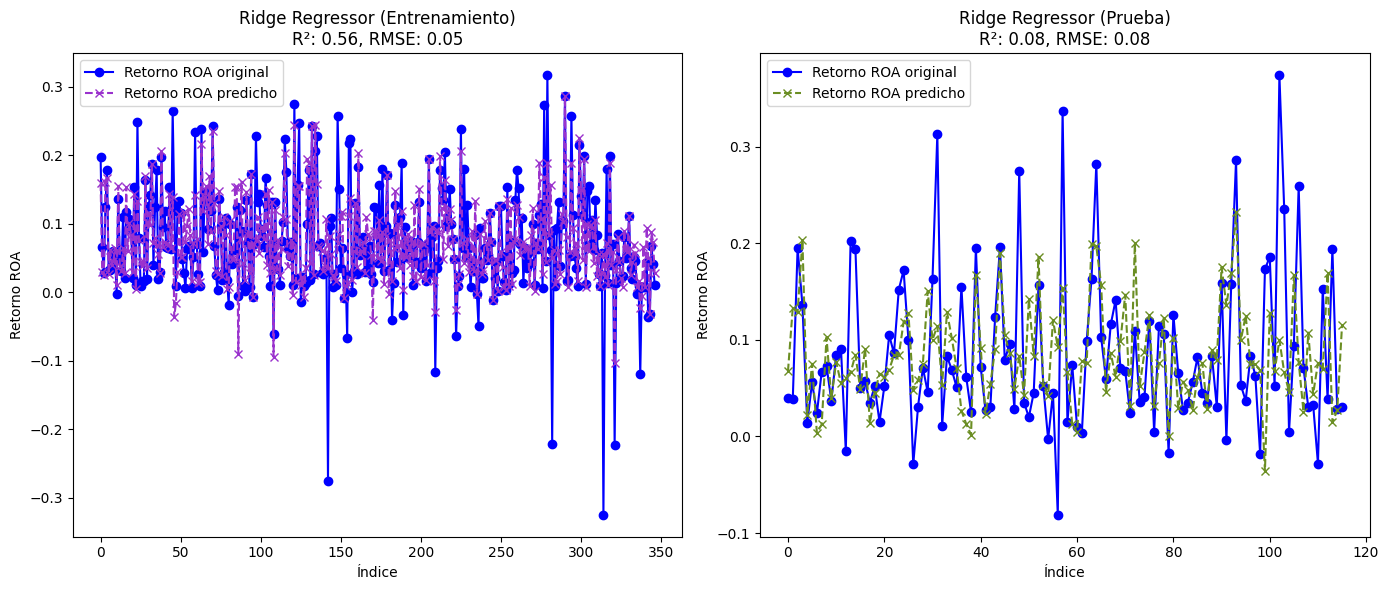

In [19]:
y_train_pred = ridge.predict(X1_train)
y_test_pred = ridge.predict(X1_test)

r2_train_ridge = r2_score(y1_train, y_train_pred)
r2_test_ridge = r2_score(y1_test, y_test_pred)

rmse_train_ridge = np.sqrt(mean_squared_error(y1_train, y_train_pred))
rmse_test_ridge = np.sqrt(mean_squared_error(y1_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y1_train)), y1_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Ridge Regressor (Entrenamiento)\nR²: {r2_train_ridge:.2f}, RMSE: {rmse_train_ridge:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y1_test)), y1_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Ridge Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Lasso**

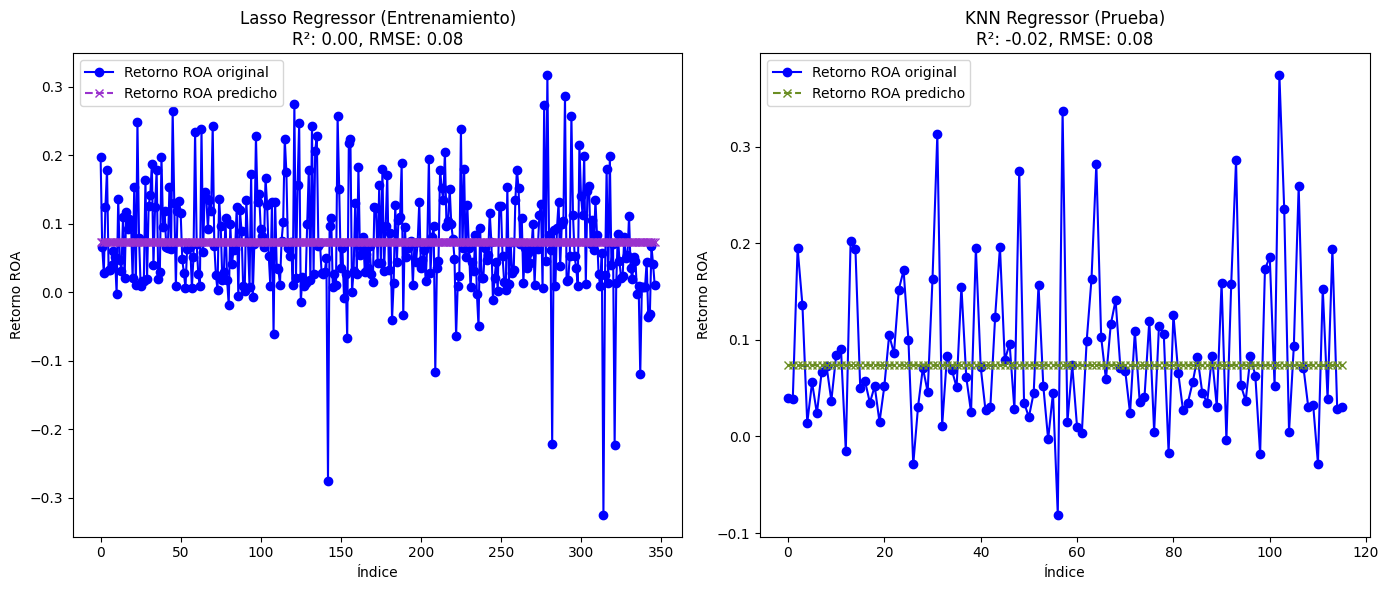

In [20]:
y_train_pred = lasso.predict(X1_train)
y_test_pred = lasso.predict(X1_test)

r2_train_lasso = r2_score(y1_train, y_train_pred)
r2_test_lasso = r2_score(y1_test, y_test_pred)

rmse_train_lasso = np.sqrt(mean_squared_error(y1_train, y_train_pred))
rmse_test_lasso = np.sqrt(mean_squared_error(y1_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y1_train)), y1_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Lasso Regressor (Entrenamiento)\nR²: {r2_train_lasso:.2f}, RMSE: {rmse_train_lasso:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y1_test)), y1_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Prueba)\nR²: {r2_test_lasso:.2f}, RMSE: {rmse_test_lasso:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

### **ROE (Return on Equity (ttm))**

In [21]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, random_state=58)
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

#### **KNN**

In [22]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': list(range(1, 100)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X2_train, y2_train)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X2_test)

r2 = r2_score(y2_test, y_pred)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print(f'R²: {r2:.2f}')

Mejores parámetros encontrados:
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 56, 'weights': 'distance'}
R²: -0.01


#### **Regresión Lineal**

In [23]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),('lr', LinearRegression())])
lr_paramgrid = {} # No tiene hiperpárametros definidos

lr_grid = GridSearchCV(lr_pipeline, param_grid = lr_paramgrid, cv = 10, scoring= 'r2')
lr_grid.fit(X2_train, y2_train)

print("Mejor score (R2) en entrenamiento:", lr_grid.best_score_)

y_pred = lr_grid.predict(X2_test)
r_square = r2_score(y2_test, y_pred)
rmse_ = np.sqrt(mean_squared_error(y2_test, y_pred))

print("R2 en el conjunto de test para Regresión Lineal:", r_square)
print("RMSE en el conjunto de test para Regresión Lineal:",rmse_)

Mejor score (R2) en entrenamiento: -1.0191370735415605e+28
R2 en el conjunto de test para Regresión Lineal: -8.18687383067227e+26
RMSE en el conjunto de test para Regresión Lineal: 30486695689088.816


#### **Regresión Ridge**

In [24]:
ridge = Ridge().fit(X2_train, y2_train)
print("Training set score: {:.2f}".format(ridge.score(X2_train, y2_train)))
print("Test set score: {:.2f}".format(ridge.score(X2_test, y2_test)))

Training set score: 0.32
Test set score: -0.04


#### **Regresión Lasso**

In [25]:
lasso = Lasso().fit(X2_train, y2_train)
print("Training set score: {:.2f}".format(lasso.score(X2_train, y2_train)))
print("Test set score: {:.2f}".format(lasso.score(X2_test, y2_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.00
Test set score: -0.01
Number of features used: 0


#### **TABLA**

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Realizar predicciones
KNN2 = best_knn.predict(X2_test)
LR2 = lr_grid.predict(X2_test)
RIDGE2 = ridge.predict(X2_test)
LASSO2 = lasso.predict(X2_test)

# Evaluar las predicciones utilizando métricas de regresión
metricas = {
    'Modelo': ['KNN', 'Regresión lineal', 'Ridge', 'Lasso'],
    'Mean Squared Error (MSE)': [
        mean_squared_error(y2_test, KNN2),  # K-NN
        mean_squared_error(y2_test, LR2),   # Regresión lineal
        mean_squared_error(y2_test, RIDGE2),
        mean_squared_error(y2_test, LASSO2)
    ],
    'Root Mean Squared Error (RMSE)': [
        np.sqrt(mean_squared_error(y2_test, KNN2)),
        np.sqrt(mean_squared_error(y2_test, LR2)),
        np.sqrt(mean_squared_error(y2_test, RIDGE2)),
        np.sqrt(mean_squared_error(y2_test, LASSO2))
    ],
    'Mean Absolute Error (MAE)': [
        mean_absolute_error(y2_test, KNN2),
        mean_absolute_error(y2_test, LR2),
        mean_absolute_error(y2_test, RIDGE2),
        mean_absolute_error(y2_test, LASSO2)
    ],
    
    'R2 score':[
        r2_score(y2_test, KNN2),
        r2_score(y2_test, LR2),
        r2_score(y2_test, RIDGE2),
        r2_score(y2_test, LASSO2)
    ],

    'Ljung-Box (p-value)': [
        residuos(y2_test, KNN2)[0],
        residuos(y2_test, LR2)[0],
        residuos(y2_test, RIDGE2)[0],
        residuos(y2_test, LASSO2)[0]
    ],
    'Jarque-Bera (p-value)': [
        residuos(y2_test, KNN2)[1],
        residuos(y2_test, LR2)[1],
        residuos(y2_test, RIDGE2)[1],
        residuos(y2_test, LASSO2)[1]
    ]
    
}

# Convertir a DataFrame para visualización
cuadro2 = pd.DataFrame(metricas)
cuadro2


,Modelo,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R2 score,Ljung-Box (p-value),Jarque-Bera (p-value)
0,KNN,1.141760e+00,1.068532e+00,3.827261e-01,-5.708837e-03,0.963556,0.000000e+00
1,Regresión lineal,9.294386e+26,3.048670e+13,9.470263e+12,-8.186874e+26,0.851248,4.300458e-148
2,Ridge,1.183243e+00,1.087770e+00,4.484291e-01,-4.224847e-02,0.961167,0.000000e+00
3,Lasso,1.148228e+00,1.071554e+00,3.590545e-01,-1.140641e-02,0.910609,0.000000e+00


En esta tabla, se observa que  los valores de **MSE**, **RMSE** y **MAE** sugieren que los modelos están teniendo dificultades para ajustarse adecuadamente a los datos.

El modelo de **Regresión Lineal** tiene un **MSE** y **MAE** demasiado altos, indicando predicciones muy erróneas, mientras que los modelos **KNN**, **Ridge** y **Lasso** tienen errores más moderados, pero aún muestran un desempeño deficiente, especialmente en términos de **R²**,  donde todos están alejados de 1 y además hay algunos negativos.

En resumen, todos los modelos parecen estar ajustándose muy mal a los datos, lo que sugiere que podría haber problemas en los datos, o bien, estos modelos no son los más adecuados para el problema en cuestión.

#### **Gráficas**

##### **KNN**

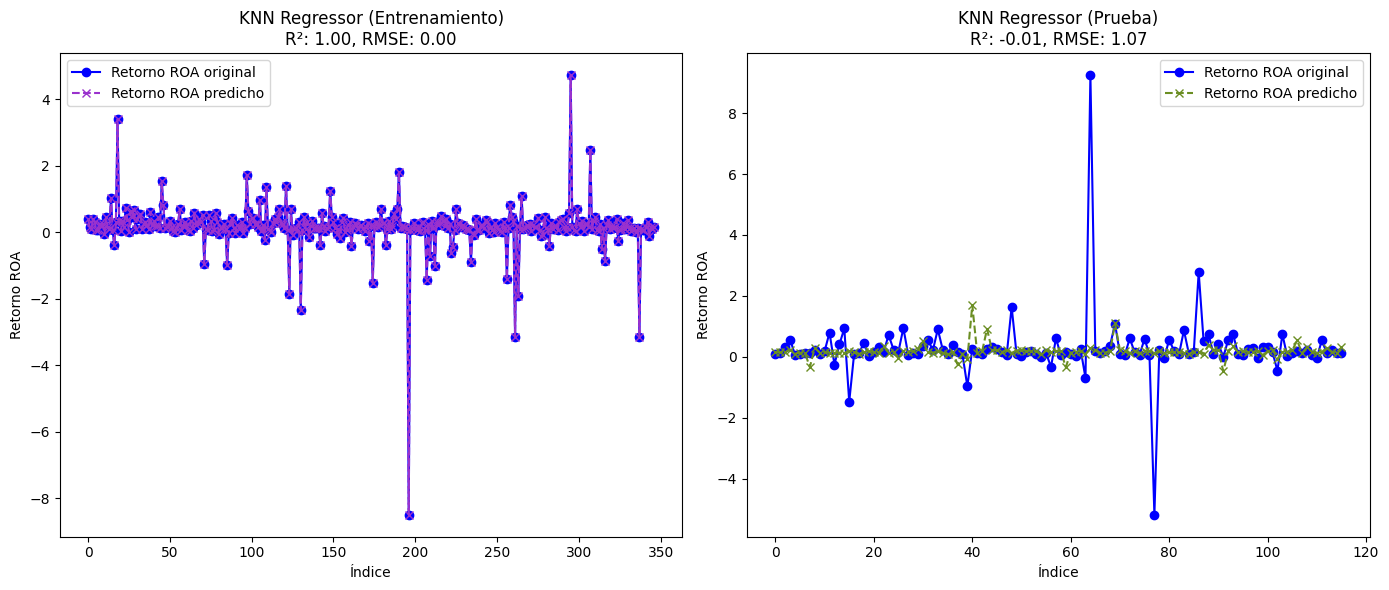

In [27]:
y_train_pred = best_knn.predict(X2_train)
y_test_pred = best_knn.predict(X2_test)

r2_train_knn = r2_score(y2_train, y_train_pred)
r2_test_knn = r2_score(y2_test, y_test_pred)

rmse_train_knn = np.sqrt(mean_squared_error(y2_train, y_train_pred))
rmse_test_knn = np.sqrt(mean_squared_error(y2_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y2_train)), y2_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Entrenamiento)\nR²: {r2_train_knn:.2f}, RMSE: {rmse_train_knn:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y2_test)), y2_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Regresión lineal**

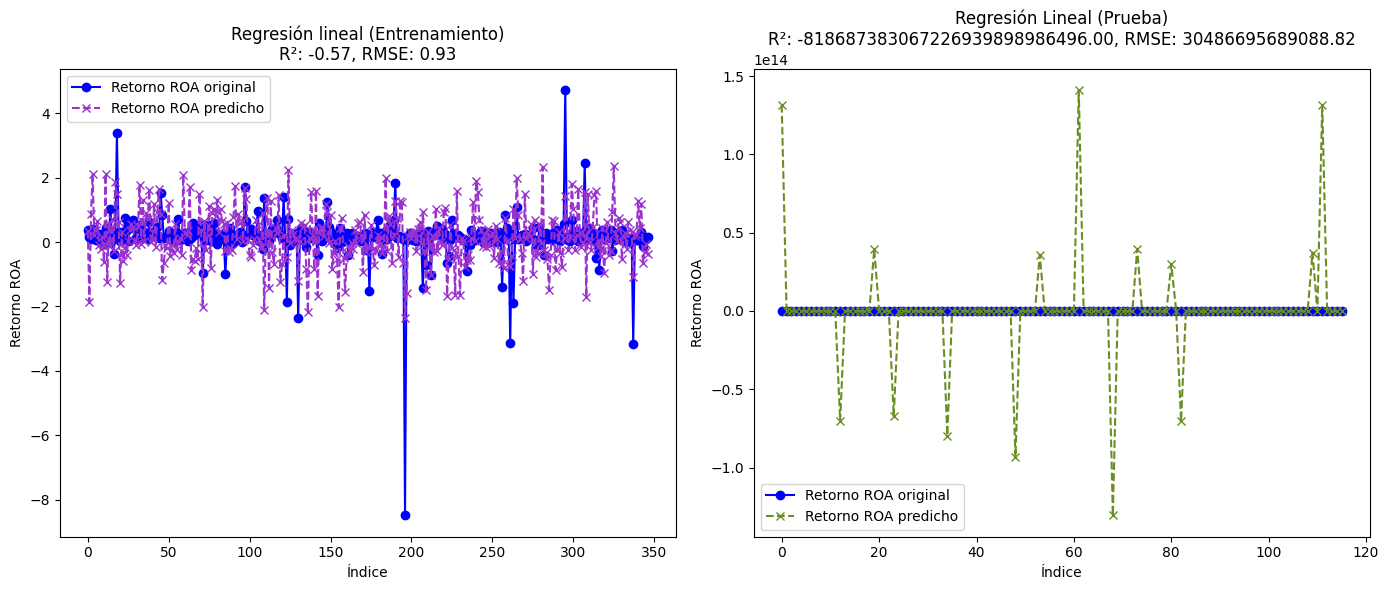

In [28]:
y_train_pred = lr_grid.predict(X2_train)
y_test_pred = lr_grid.predict(X2_test)

r2_train_lr = r2_score(y2_train, y_train_pred)
r2_test_lr = r2_score(y2_test, y_test_pred)

rmse_train_lr = np.sqrt(mean_squared_error(y2_train, y_train_pred))
rmse_test_lr = np.sqrt(mean_squared_error(y2_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y2_train)), y2_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Regresión lineal (Entrenamiento)\nR²: {r2_train_lr:.2f}, RMSE: {rmse_train_lr:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y2_test)), y2_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Regresión Lineal (Prueba)\nR²: {r2_test_lr:.2f}, RMSE: {rmse_test_lr:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Regresión Ridge**

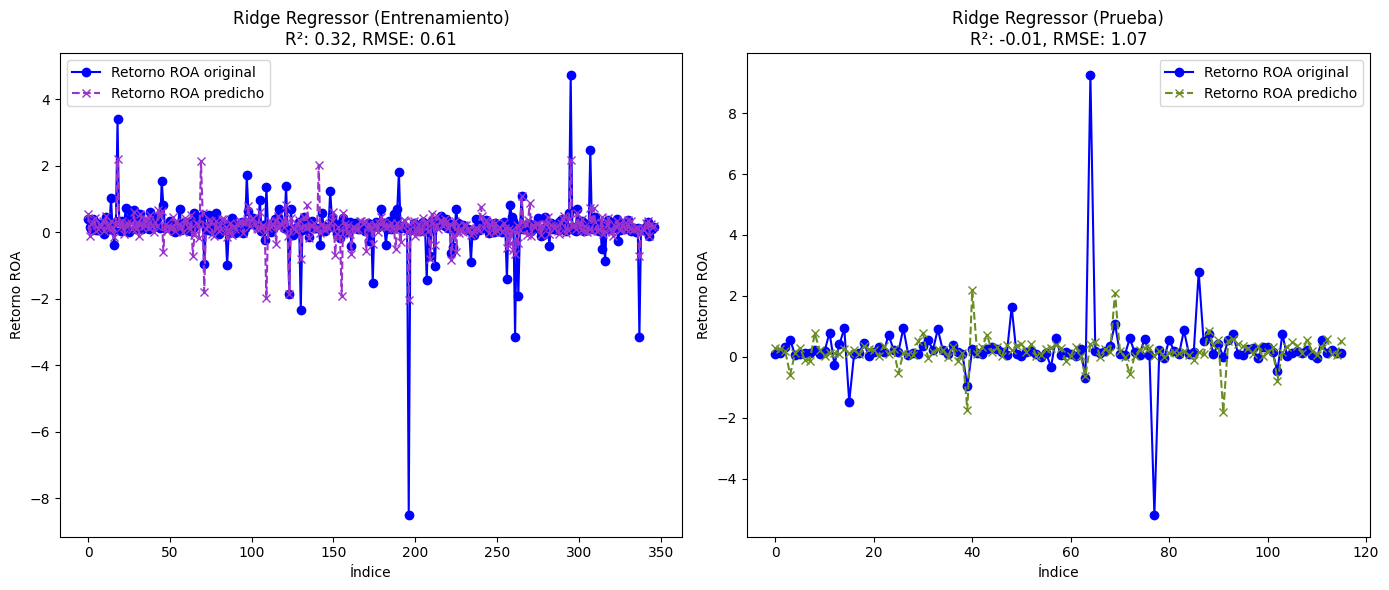

In [29]:
y_train_pred = ridge.predict(X2_train)
y_test_pred = ridge.predict(X2_test)

r2_train_ridge = r2_score(y2_train, y_train_pred)
r2_test_ridge = r2_score(y2_test, y_test_pred)

rmse_train_ridge = np.sqrt(mean_squared_error(y2_train, y_train_pred))
rmse_test_ridge = np.sqrt(mean_squared_error(y2_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y2_train)), y2_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Ridge Regressor (Entrenamiento)\nR²: {r2_train_ridge:.2f}, RMSE: {rmse_train_ridge:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y2_test)), y2_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Ridge Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Regresión Lasso**

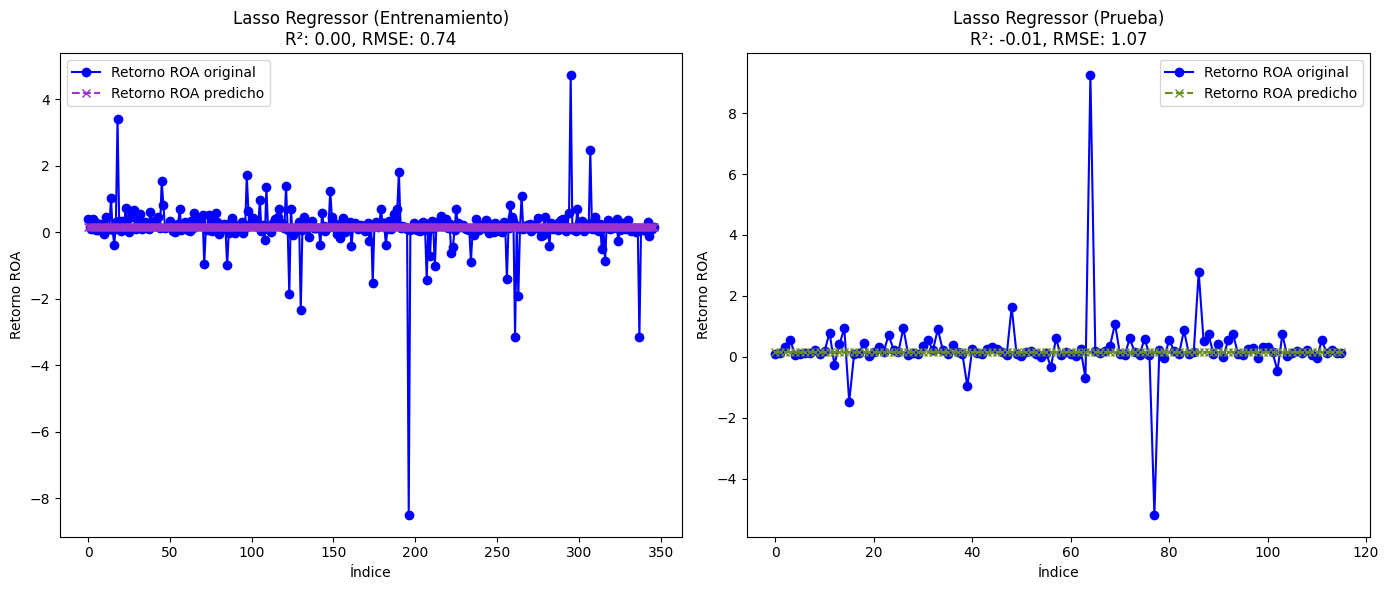

In [30]:
y_train_pred = lasso.predict(X2_train)
y_test_pred = lasso.predict(X2_test)

r2_train_lasso = r2_score(y2_train, y_train_pred)
r2_test_lasso = r2_score(y2_test, y_test_pred)

rmse_train_lasso = np.sqrt(mean_squared_error(y2_train, y_train_pred))
rmse_test_lasso = np.sqrt(mean_squared_error(y2_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y2_train)), y2_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Lasso Regressor (Entrenamiento)\nR²: {r2_train_lasso:.2f}, RMSE: {rmse_train_lasso:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y2_test)), y2_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Lasso Regressor (Prueba)\nR²: {r2_test_lasso:.2f}, RMSE: {rmse_test_lasso:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

### **ROI (Return on Investment (ttm))**

In [31]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, random_state=58)
scaler = StandardScaler()
X3_train = scaler.fit_transform(X3_train)
X3_test = scaler.transform(X3_test)

#### **KNN**

In [32]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': list(range(1, 100)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X3_train, y3_train)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X3_test)

r2 = r2_score(y3_test, y_pred)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print(f'R²: {r2:.2f}')

Mejores parámetros encontrados:
{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'distance'}
R²: 0.14


#### **Regresión Lineal**

In [33]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),('lr', LinearRegression())])
lr_paramgrid = {} # No tiene hiperpárametros definidos

lr_grid = GridSearchCV(lr_pipeline, param_grid = lr_paramgrid, cv = 10, scoring= 'r2')
lr_grid.fit(X3_train, y3_train)

print("Mejor score (R2) en entrenamiento:", lr_grid.best_score_)

y_pred = lr_grid.predict(X3_test)
r_square = r2_score(y3_test, y_pred)
rmse_ = np.sqrt(mean_squared_error(y3_test, y_pred))

print("R2 en el conjunto de test para Regresión Lineal:", r_square)
print("RMSE en el conjunto de test para Regresión Lineal:",rmse_)

Mejor score (R2) en entrenamiento: -2.663436020108018e+27
R2 en el conjunto de test para Regresión Lineal: -1.2744910434337766e+26
RMSE en el conjunto de test para Regresión Lineal: 3670913933277.1274


#### **Regresión Ridge**

In [34]:
ridge = Ridge().fit(X3_train, y3_train)
print("Training set score: {:.2f}".format(ridge.score(X3_train, y3_train)))
print("Test set score: {:.2f}".format(ridge.score(X3_test, y3_test)))

Training set score: 0.54
Test set score: 0.15


#### **Regresión Lasso**

In [35]:
lasso = Lasso().fit(X3_train, y3_train)
print("Training set score: {:.2f}".format(lasso.score(X3_train, y3_train)))
print("Test set score: {:.2f}".format(lasso.score(X3_test, y3_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.00
Test set score: -0.01
Number of features used: 0


####  **TABLA**

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Realizar predicciones
KNN3 = best_knn.predict(X3_test)
LR3 = lr_grid.predict(X3_test)
RIDGE3 = ridge.predict(X3_test)
LASSO3 = lasso.predict(X3_test)

# Evaluar las predicciones utilizando métricas de regresión
metricas = {
    'Modelo': ['KNN', 'Regresión lineal', 'Ridge', 'Lasso'],
    'Mean Squared Error (MSE)': [
        mean_squared_error(y3_test, KNN3),  # K-NN
        mean_squared_error(y3_test, LR3),   # Regresión lineal
        mean_squared_error(y3_test, RIDGE3),
        mean_squared_error(y3_test, LASSO3)
    ],
    'Root Mean Squared Error (RMSE)': [
        np.sqrt(mean_squared_error(y3_test, KNN3)),
        np.sqrt(mean_squared_error(y3_test, LR3)),
        np.sqrt(mean_squared_error(y3_test, RIDGE3)),
        np.sqrt(mean_squared_error(y3_test, LASSO3))
    ],
    'Mean Absolute Error (MAE)': [
        mean_absolute_error(y3_test, KNN3),
        mean_absolute_error(y3_test, LR3),
        mean_absolute_error(y3_test, RIDGE3),
        mean_absolute_error(y3_test, LASSO3)
    ],
    'R2 score':[
        r2_score(y3_test, KNN3),
        r2_score(y3_test, LR3),
        r2_score(y3_test, RIDGE3),
        r2_score(y3_test, LASSO2)
    ],

    'Ljung-Box (p-value)': [
        residuos(y3_test, KNN3)[0],
        residuos(y3_test, LR3)[0],
        residuos(y3_test, RIDGE3)[0],
        residuos(y3_test, LASSO3)[0]
    ],
    'Jarque-Bera (p-value)': [
        residuos(y3_test, KNN3)[1],
        residuos(y3_test, LR3)[1],
        residuos(y3_test, RIDGE3)[1],
        residuos(y3_test, LASSO3)[1]
    ]
    
}

# Convertir a DataFrame para visualización
cuadro3 = pd.DataFrame(metricas)
cuadro3


,Modelo,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R2 score,Ljung-Box (p-value),Jarque-Bera (p-value)
0,KNN,9.118282e-02,3.019649e-01,1.134780e-01,1.376146e-01,0.993825,0.000000e+00
1,Regresión lineal,1.347561e+25,3.670914e+12,1.115009e+12,-1.274491e+26,0.519615,9.660907e-182
2,Ridge,8.986472e-02,2.997745e-01,1.188022e-01,1.500809e-01,0.987171,0.000000e+00
3,Lasso,1.068428e-01,3.268682e-01,1.299803e-01,-6.212029e-03,0.947695,0.000000e+00


En esta tabla, se observa que  los valores de **MSE**, **RMSE** y **MAE** sugieren que los modelos y los datos no se ajstan tambien entre sí.

El modelo de **Regresión Lineal** tiene un **MSE** y **MAE** extremadamente altos, indicando predicciones desastrosamente erróneas, mientras que los modelos **KNN**, **Ridge** y **Lasso** tienen errores más moderados, pero aún muestran un desempeño deficiente, especialmente en términos de **R²**.

En resumen, todos los modelos parecen estar ajustándose muy mal a los datos, lo que sugiere que podría haber problemas en los datos, o bien, estos modelos no son los más adecuados para el problema en cuestión.

#### **Gráficas**

##### **KNN**

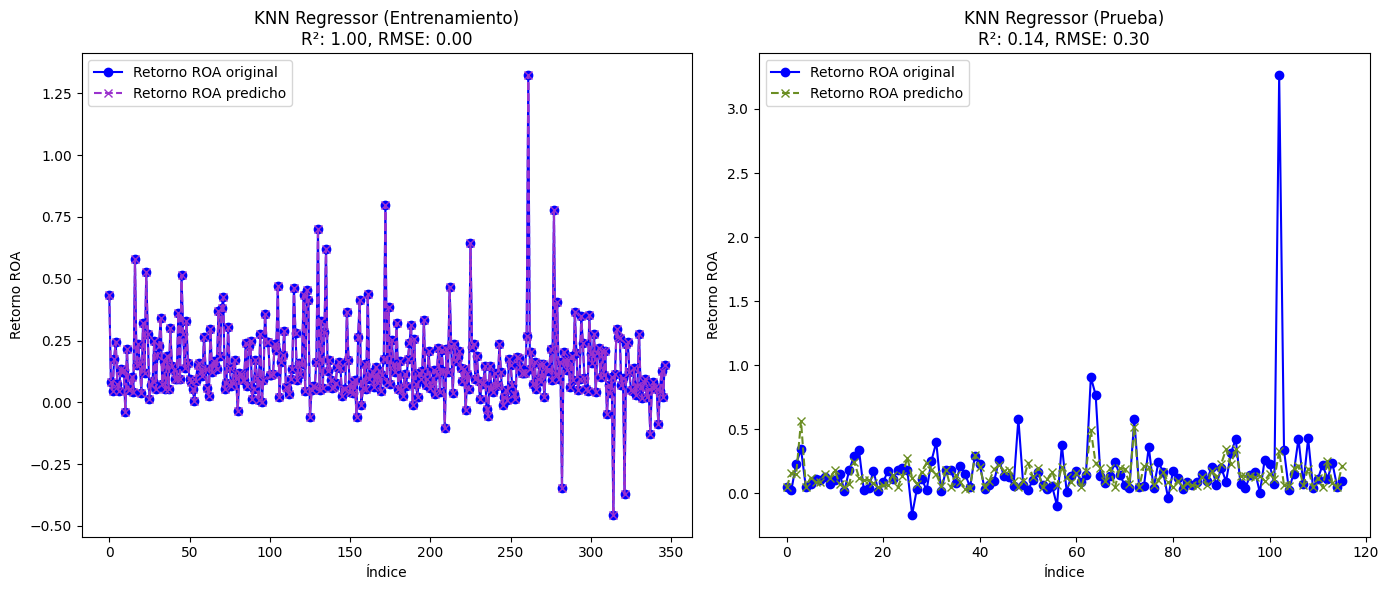

In [37]:
y_train_pred = best_knn.predict(X3_train)
y_test_pred = best_knn.predict(X3_test)

r2_train_knn = r2_score(y3_train, y_train_pred)
r2_test_knn = r2_score(y3_test, y_test_pred)

rmse_train_knn = np.sqrt(mean_squared_error(y3_train, y_train_pred))
rmse_test_knn = np.sqrt(mean_squared_error(y3_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y3_train)), y3_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Entrenamiento)\nR²: {r2_train_knn:.2f}, RMSE: {rmse_train_knn:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y3_test)), y3_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"KNN Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Regresión lineal**

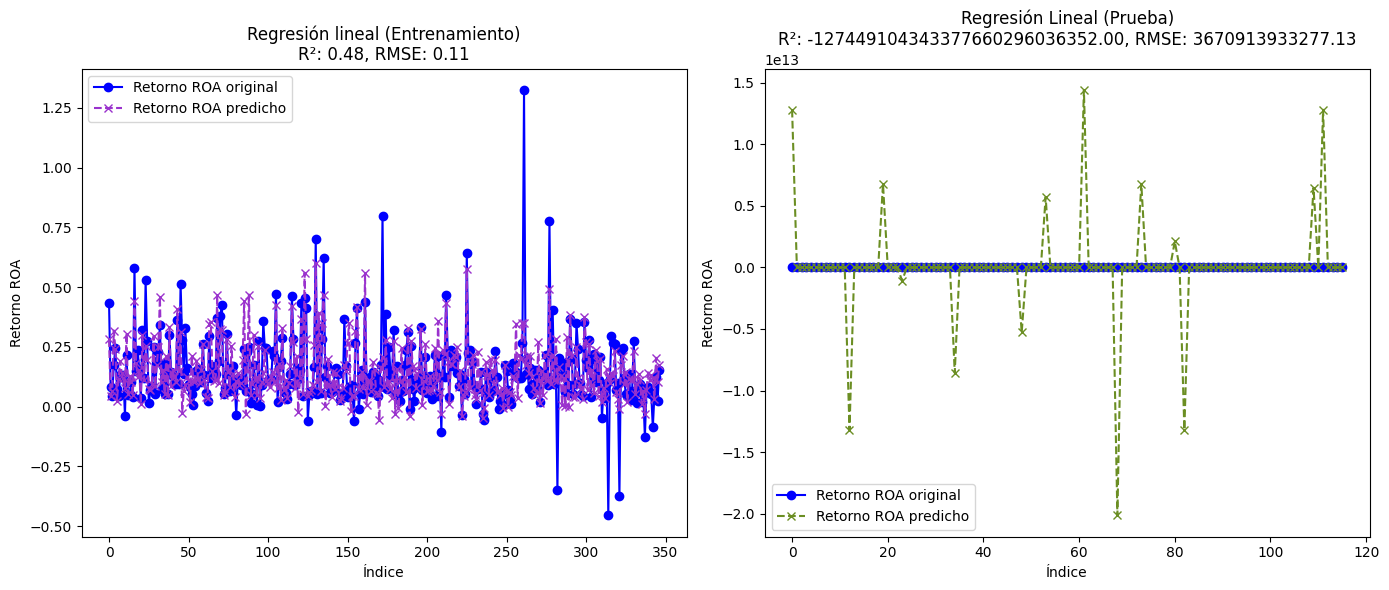

In [38]:
y_train_pred = lr_grid.predict(X3_train)
y_test_pred = lr_grid.predict(X3_test)

r2_train_lr = r2_score(y3_train, y_train_pred)
r2_test_lr = r2_score(y3_test, y_test_pred)

rmse_train_lr = np.sqrt(mean_squared_error(y3_train, y_train_pred))
rmse_test_lr = np.sqrt(mean_squared_error(y3_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y3_train)), y3_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Regresión lineal (Entrenamiento)\nR²: {r2_train_lr:.2f}, RMSE: {rmse_train_lr:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y3_test)), y3_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Regresión Lineal (Prueba)\nR²: {r2_test_lr:.2f}, RMSE: {rmse_test_lr:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Ridge**

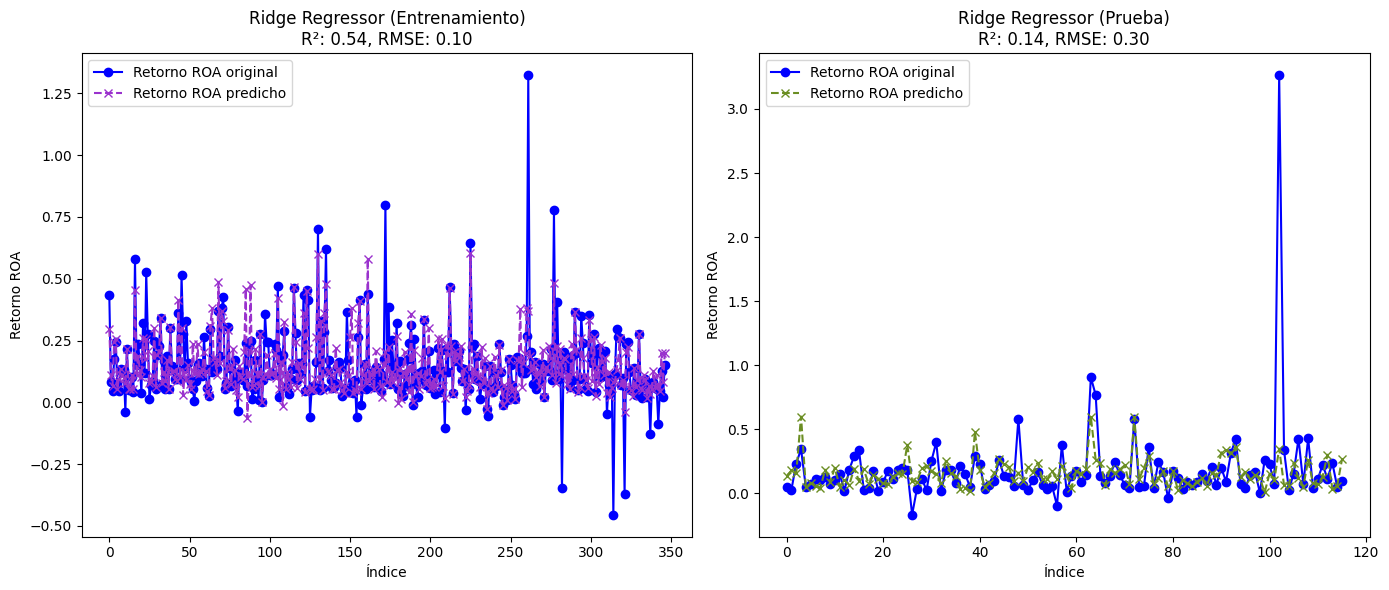

In [39]:
y_train_pred = ridge.predict(X3_train)
y_test_pred = ridge.predict(X3_test)

r2_train_ridge = r2_score(y3_train, y_train_pred)
r2_test_ridge = r2_score(y3_test, y_test_pred)

rmse_train_ridge = np.sqrt(mean_squared_error(y3_train, y_train_pred))
rmse_test_ridge = np.sqrt(mean_squared_error(y3_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y3_train)), y3_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Ridge Regressor (Entrenamiento)\nR²: {r2_train_ridge:.2f}, RMSE: {rmse_train_ridge:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y3_test)), y3_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Ridge Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

##### **Lasso**

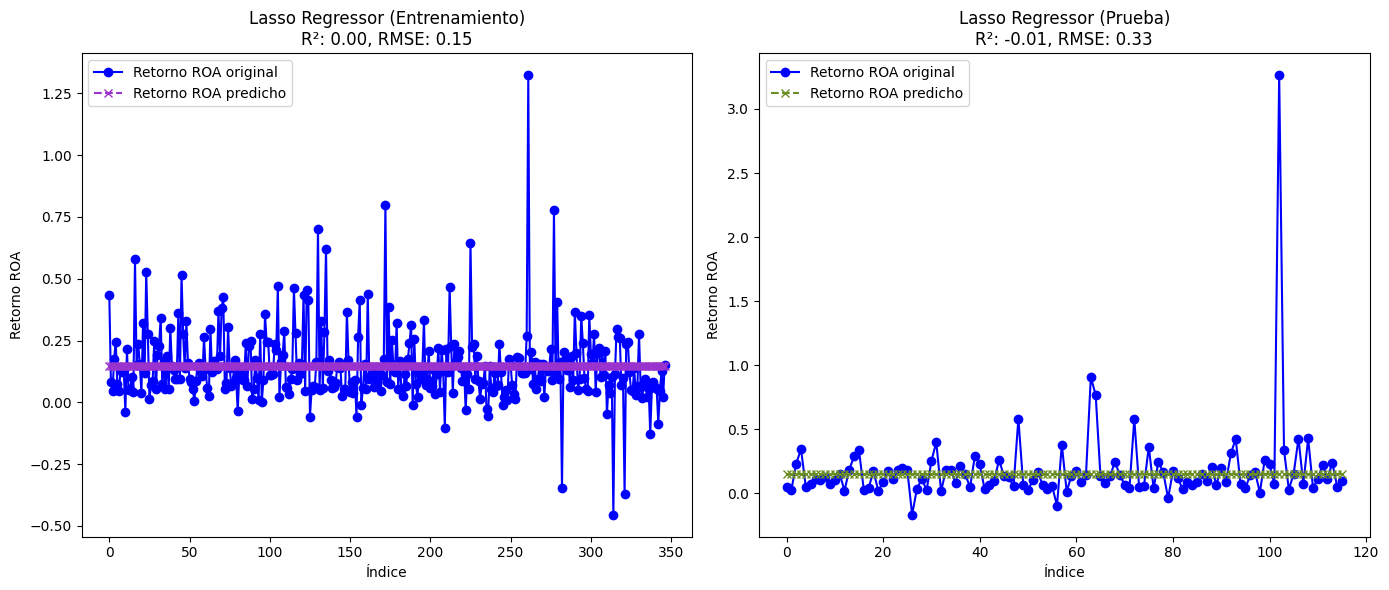

In [40]:
y_train_pred = lasso.predict(X3_train)
y_test_pred = lasso.predict(X3_test)

r2_train_lasso = r2_score(y3_train, y_train_pred)
r2_test_lasso = r2_score(y3_test, y_test_pred)

rmse_train_lasso = np.sqrt(mean_squared_error(y3_train, y_train_pred))
rmse_test_lasso = np.sqrt(mean_squared_error(y3_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y3_train)), y3_train, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Retorno ROA predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Lasso Regressor (Entrenamiento)\nR²: {r2_train_lasso:.2f}, RMSE: {rmse_train_lasso:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y3_test)), y3_test, label="Retorno ROA original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Retorno ROA predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Retorno ROA")
plt.title(f"Lasso Regressor (Prueba)\nR²: {r2_test_lasso:.2f}, RMSE: {rmse_test_lasso:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

### **Interpretación general**

Para este ejercicio, vamos a realizar una interpretación general dado que presentan las mismas características. Se observa que ninguno de los modelos predice adecuadamente el comportamiento de los datos. Esto probablemente se debe a que las bases de datos utilizadas no están alineadas temporalmente: una contiene información de hace 5 meses, mientras que los índices financieros son de hace 2 años. Este desajuste temporal puede introducir cambios estructurales en los datos que los modelos no pueden capturar correctamente, afectando negativamente la precisión de las predicciones.